# Automate augmentation and processing of hand-written tabular data from invoices using Amazon Textract and Amazon A2I
Organizations across industries have a large number of hand-written documents such as employment forms, invoices, and receipts that require processing as part of their operations. Extracting data from these documents especially when there is a combination of printed and handwritten text is error-prone, time-consuming, expensive, and does not scale. Text being embedded in tables and forms adds to the extraction and processing complexity. Amazon Textract is a fully managed ML service that automatically extracts printed text, handwriting, and other data from scanned documents that goes beyond simple optical character recognition (OCR) to identify, understand, and extract data from forms and tables.

Once the data and text is extracted, the post processing step in a document management workflow involves reviewing the entries and make changes as needed. Amazon A2I makes it easy to integrate a human review into your ML workflow. This allows you to automatically have humans step into your ML pipeline to review results below a confidence threshold, set up review and auditing workflows, and augment the prediction results to improve model accuracy

In this notebook we show you how to use Amazon Textract to extract the content of your forms containing hand-written text, setup and send to a human review loop, and augment the extracted invoice content for downstream processing.

* Step 0 - Install and import libraries
* Step 1 - Review the sample data and setup Amazon Textract helper function
* Step 2 - Inspect and analyze the Amazon Textract's response
* Step 3 - Send Amazon Textract response to Amazon A2I human loop
* Step 4 - Verify Amazon Textract response in Amazon A2I Console and add corrections
* Step 5 - Store the Amazon Textract and human reviewed response for downstream processing

## Step 0 - Install and Import Libraries

We will be using the data science library [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for invoice content analysis, the [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/), and [AWS boto3 python sdk](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with Amazon Textract and Amazon A2I. Let's now install and import them.

In [3]:
import pandas as pd
import webbrowser, os
import json
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

### Setup a private review workforce

This step requires you to use the AWS Console. However, we highly recommend that you follow it, especially when creating your own task with a custom template we will use for this notebook. We will create a private workteam and add only one user (you) to it.

To create a private team:

   1. Go to AWS Console > Amazon SageMaker > Labeling workforces
   1. Click "Private" and then "Create private team".
   1. Enter the desired name for your private workteam.
   1. Enter your own email address in the "Email addresses" section.
   1. Enter the name of your organization and a contact email to administer the private workteam.
   1. Click "Create Private Team".
   1. The AWS Console should now return to AWS Console > Amazon SageMaker > Labeling workforces. Your newly created team should be visible under "Private teams". Next to it you will see an ARN which is a long string that looks like arn:aws:sagemaker:region-name-123456:workteam/private-crowd/team-name. Please copy this ARN to paste in the cell below.
   1. You should get an email from no-reply@verificationemail.com that contains your workforce username and password.
   1. In AWS Console > Amazon SageMaker > Labeling workforces, click on the URL in Labeling portal sign-in URL. Use the email/password combination from Step 8 to log in (you will be asked to create a new, non-default password).
   1. This is your private worker's interface. When we create a verification task in Verify your task using a private team below, your task should appear in this window. You can invite your colleagues to participate in the labeling job by clicking the "Invite new workers" button.

Please refer to the Amazon SageMaker documentation if you need more details.

In [2]:
# Enter the Workteam ARN from step 7 above
WORKTEAM_ARN= "<WORKTEAM_ARN>"
 
# Define IAM role
role = get_execution_role()
#print("RoleArn: {}".format(role))
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'textract-a2i-handwritten'

## Step 1 - Review the sample data and setup Amazon Textract helper function

In this step, we will look at the invoice input image test_invoice.png. Use Amazon Textract to read the hand-written content present in the invoice line items table, and load this into a pandas dataframe for analysis.

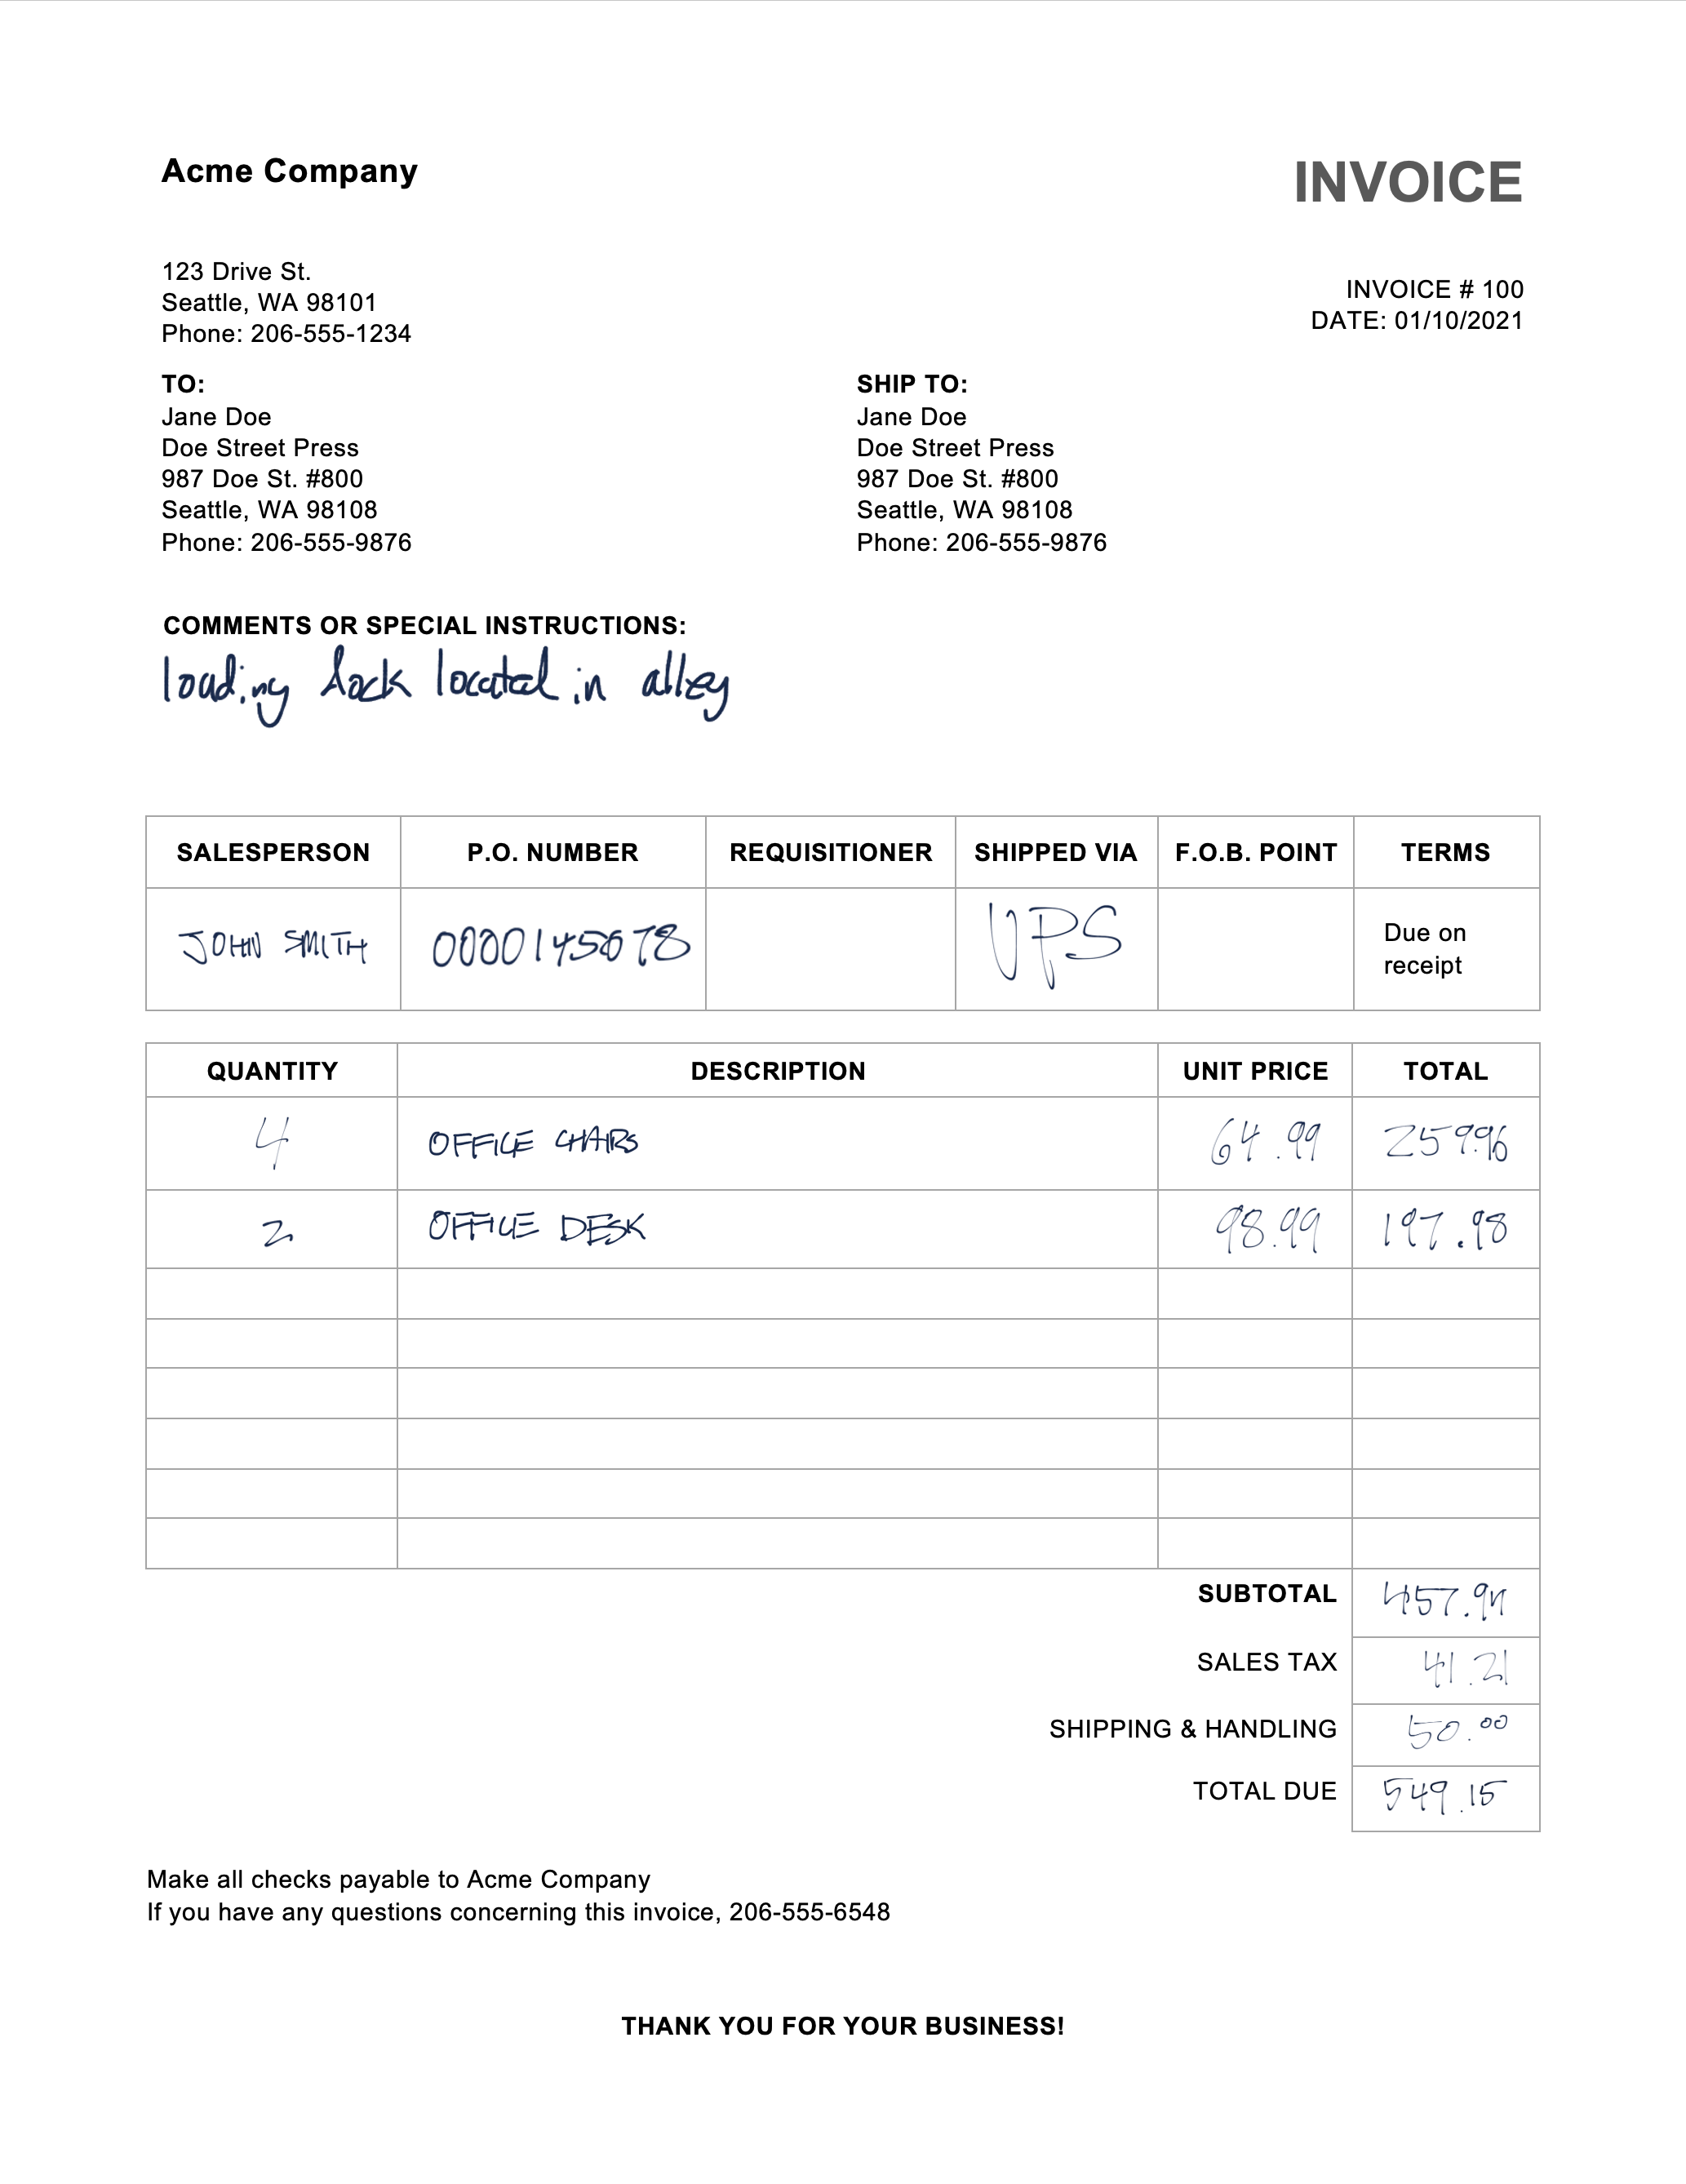

In [4]:
# Document
documentName = "A2I-InvoiceSample-Handwritten.png"

display(Image(filename=documentName))

### Setting up helper functions to parse Amazon Textract response

In [4]:
from utils.texthelper import *

### Extract rows and columns from tables in image files

In this notebook, we will use the Amazon Textract Sync API for document extraction, [AnalyzeDocument](https://docs.aws.amazon.com/textract/latest/dg/API_AnalyzeDocument.html). This accepts image files (png or jpeg) as an input. If you would like to use this notebook with a PDF file of an invoice or for batch processing, use the [StartDocumentAnalysis API](https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentAnalysis.html). StartDocumentAnalysis returns a job identifier (JobId) that you use to get the results of the operation. When text analysis is finished, Amazon Textract publishes a completion status to the Amazon Simple Notification Service (Amazon SNS) topic that you specify in NotificationChannel. To get the results of the text analysis operation, first check that the status value published to the Amazon SNS topic is SUCCEEDED. If so, call GetDocumentAnalysis, and pass the job identifier (JobId) from the initial call to StartDocumentAnalysis.

Generate CSV File from the Amazon Textract response using the helper functions. Execute the cell below to review the helper function.

In [5]:
# Execute this cell if you want to review the helper functions
!pygmentize "utils/texthelper.py"

from pprint import pprint
import boto3

def get_test():
    print("test successful")

def get_rows_columns_map(table_result, blocks_map):
    rows = {}
    for relationship in table_result['Relationships']:
        if relationship['Type'] == 'CHILD':
            for child_id in relationship['Ids']:
                cell = blocks_map[child_id]
                if cell['BlockType'] == 'CELL':
                    row_index = cell['RowIndex']
                    col_index = cell['ColumnIndex']
                    if row_index not in rows:
                        # create new row
                        rows[row_index] = {}

                    # get the text value
                    rows[row_index][col_index] = get_text(cell, blocks_map)
    return rows


def get_text(result, blocks_map):
    text = ''
    if 'Relationships' in result:
        for relationship in result['Relationships']:
            if relationship['Type'] == 'CHILD':
                for child_id in relationship['Ids']:
   

Now we are ready to use the helper functions to extract the contents from our image file using Amazon Textract

In [6]:
# Return the URLs of the uploaded file, so they can be reviewed or used elsewhere
s3_img_url = S3Uploader.upload('A2I-InvoiceSample-Handwritten.png', 's3://{}/{}'.format(bucket, prefix))

# create a csv file out of the table
table_csv = get_table_csv_results('A2I-InvoiceSample-Handwritten.png')
output_file = 'invoice_handwritten_output.csv'

# replace content
with open(output_file, "wt") as fout:
    fout.write(table_csv)

# show the results
print('CSV OUTPUT FILE: ', output_file)

Image loaded A2I-InvoiceSample-Handwritten.png
CSV OUTPUT FILE:  invoice_handwritten_output.csv


## Step 2 - Inspect and analyze Amazon Textract's response

We will now load the form line items into a pandas dataframe, and clean it up to ensure we have the relevant columns and rows that downstream applications need. We will then send it to Amazon A2I for human review, and augmentation.

In [7]:
# Load the csv file contents into a dataframe, select rows of interest, strip out extra spaces, use comma as delimiter
df_raw = pd.read_csv('invoice_handwritten_output.csv', header=1, nrows=16, sep=r',(?=\S)')
# now replace commas in column values
df_raw = df_raw.replace(',','', regex=True)
# change column names
df_raw = df_raw.rename(columns={"TOTAL ,": "TOTAL"})
# drop the rows with NaN values and no other meaningful content
df_raw = df_raw.dropna(thresh=2)
# replace the NaN values to None to prevent issues with JSON conversion
df_raw = df_raw.where(df_raw.notnull(), None)
# reset index
df_raw = df_raw.reset_index(drop=True)
# display the dataframe
df_raw

,QUANTITY,DESCRIPTION,UNIT PRICE,TOTAL
0,4,OFFICE CHAIRS,64.99,25996
1,2,OFFICE DESK,98.99,197.98
2,None,None,SUBTOTAL,457.9n
3,None,None,SALES TAX,41.21
4,None,SHIPPING,& HANDLING,50.00
5,None,None,TOTAL DUE,549.15


## Step 3 - Send to Amazon A2I human loop

In this step, we will send the form line items in a tabular form to an Amazon A2I human loop for review, and modifications/augmentation to the data as required. Once this is done, we will persist this updated data in a DynamoDB table so downstream applications can use for processing.

In [8]:

timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon S3 client 
s3 = boto3.client('s3')

# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-hw-invoice-' + timestamp

# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-hw-invoice-' + timestamp

# Flow definition outputs
OUTPUT_PATH = f's3://' + sess.default_bucket() + '/' + prefix + '/a2i-results'

### Step 3b - Create the human task UI

Create a human task UI resource, giving a UI template in liquid html. This template will be rendered to the human workers whenever human loop is required. For over 70 pre built UIs, check: https://github.com/aws-samples/amazon-a2i-sample-task-uis. But first, lets declare some variables that we need during the next set of steps.

In [9]:
# We customized the tabular template for our notebook as below
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<style>
  table, tr, th, td {
    border: 1px solid black;
    border-collapse: collapse;
    padding: 5px;
  }
</style>

<crowd-form>
    <div>
        <h1>Instructions</h1>
        <p>Please review the line items in the forms table, and make corrections in the Amazon Textract Output table below, where appropriate. </p>
        <p> Here are the fields you can adjust: </p>
        <p> Quantity </p>
        <p> Description </p>
        <p> Unit Price </p>
        <p> Total </p>
    </div>
    <div>
      <h3>ACME Company Invoice</h3>
      <classification-target>
        <img style="width: 100%; max-height: 40%; margin-bottom: 10px" src="{{ task.input.image1 | grant_read_access }}"/>
        
      </classification-target>
      
   </div>
    <br>
    <h1> Please enter your corrections below </h1>
    <table>
      <tr>
        <th>LINE ITEM</th>
        <th>QUANTITY</th>
        <th>DESCRIPTION</th>
        <th>UNIT PRICE</th>
        <th>TOTAL</th>
        <th>ACCEPTABLE?</th>
        <th>TRUE QUANTITY</th>
        <th>TRUE DESCRIPTION</th>
        <th>TRUE UNIT PRICE</th>
        <th>TRUE TOTAL</th>
        <th>COMMENTS</th>
      </tr>

      {% for pair in task.input.Pairs %}

        <tr>
          <td>{{ pair.row }}</td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.quantity }}"></crowd-text-area></td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.description }}"></crowd-text-area></td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.unitprice }}"></crowd-text-area></td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.total }}"></crowd-text-area></td>
          <td>
            <p>
              <input type="radio" id="agree{{ forloop.index }}" name="rating{{ forloop.index }}" value="agree" required>
              <label for="agree{{ forloop.index }}">YES</label>
            </p>
            <p>
              <input type="radio" id="disagree{{ forloop.index }}" name="rating{{ forloop.index }}" value="disagree" required>
              <label for="disagree{{ forloop.index }}">NO</label>
            </p>
          </td>
          <td>
            <p>
            <input type="text" name="TrueQuantity{{ forloop.index }}" placeholder="Corrected Quantity" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="TrueDescription{{ forloop.index }}" placeholder="Corrected Description" />
            </p>
           </td>
          <td>
            <p>
            <input type="text" name="TrueUnitPrice{{ forloop.index }}" placeholder="Corrected Unit Price" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="TrueTotal{{ forloop.index }}" placeholder="Corrected Total" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="Change Reason{{ forloop.index }}" placeholder="Explain why you changed the value" />
            </p>
           </td>
        </tr>

      {% endfor %}

    </table>
</crowd-form>
"""

def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [10]:
# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
#print(humanTaskUiArn)

### Step 3b - Create the Flow Definition
In this section, we're going to create a flow definition definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* Where your output data will be stored.
* This demo is going to use the API, but you can optionally create this workflow definition in the console as well. 

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.

In [11]:
create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= role,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Review the table contents and correct values as indicated",
            "TaskTitle": "ACME Invoice Review"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [12]:
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Initializing
Active
Flow Definition is active


In [13]:
df_raw

,QUANTITY,DESCRIPTION,UNIT PRICE,TOTAL
0,4,OFFICE CHAIRS,64.99,25996
1,2,OFFICE DESK,98.99,197.98
2,None,None,SUBTOTAL,457.9n
3,None,None,SALES TAX,41.21
4,None,SHIPPING,& HANDLING,50.00
5,None,None,TOTAL DUE,549.15


# Sending predictions to Amazon A2I human loops

In [14]:
NUM_TO_REVIEW = len(df_raw) # number of line items to review
dfqty = df_raw['QUANTITY '].to_list()
dfdes = df_raw['DESCRIPTION '].to_list()
dfup = df_raw['UNIT PRICE '].to_list()
dftot = df_raw['TOTAL'].to_list()
item_list = [{'row': "{}".format(x), 'quantity': dfqty[x], 'description': dfdes[x], 'unitprice': dfup[x], 'total': dftot[x]} for x in range(NUM_TO_REVIEW)]
item_list

[{'row': '0',
  'quantity': 4.0,
  'description': 'OFFICE CHAIRS ',
  'unitprice': '64.99 ',
  'total': '25996 '},
 {'row': '1',
  'quantity': 2.0,
  'description': 'OFFICE DESK ',
  'unitprice': '98.99 ',
  'total': '197.98 '},
 {'row': '2',
  'quantity': None,
  'description': None,
  'unitprice': 'SUBTOTAL ',
  'total': '457.9n '},
 {'row': '3',
  'quantity': None,
  'description': None,
  'unitprice': 'SALES TAX ',
  'total': '41.21 '},
 {'row': '4',
  'quantity': None,
  'description': 'SHIPPING ',
  'unitprice': '& HANDLING ',
  'total': '50.00 '},
 {'row': '5',
  'quantity': None,
  'description': None,
  'unitprice': 'TOTAL DUE ',
  'total': '549.15 '}]

In [15]:
ip_content = {"table": df_raw.reset_index().drop(columns = ['index']).head(NUM_TO_REVIEW).to_html(), 
              'Pairs': item_list,
              'image1': s3_img_url
             }

In [16]:
# Activate human loops
import json
humanLoopName = str(uuid.uuid4())

start_loop_response = a2i.start_human_loop(
            HumanLoopName=humanLoopName,
            FlowDefinitionArn=flowDefinitionArn,
            HumanLoopInput={
                "InputContent": json.dumps(ip_content)
            }
        )

Check status of human loop

In [17]:
completed_human_loops = []
resp = a2i.describe_human_loop(HumanLoopName=humanLoopName)
print(f'HumanLoop Name: {humanLoopName}')
print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
#print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
print('\n')
    
if resp["HumanLoopStatus"] == "Completed":
    completed_human_loops.append(resp)

HumanLoop Name: fcafc9e5-68f2-43d8-a9dd-d123b159abf0
HumanLoop Status: InProgress




In [18]:
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!
https://ett1xdnzkd.labeling.us-east-1.sagemaker.aws


In [36]:
completed_human_loops = []
resp = a2i.describe_human_loop(HumanLoopName=humanLoopName)
print(f'HumanLoop Name: {humanLoopName}')
print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
#print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
print('\n')
    
if resp["HumanLoopStatus"] == "Completed":
    completed_human_loops.append(resp)

HumanLoop Name: fcafc9e5-68f2-43d8-a9dd-d123b159abf0
HumanLoop Status: Completed




#### Let's review the annotation output

In [38]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' + sess.default_bucket()  + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]

    response = s3.get_object(Bucket=sess.default_bucket(), Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    #pp.pprint(json_output)
    print('\n')

## Step 5 - Store the results in DynamoDB

We will now store the form with updated contents into a DynamoDB table, so downstream applications can make use of it. To automate the process, simply setup an [AWS Lambda trigger with DynamoDB](https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/Streams.Lambda.html), to automatically extract and send information to your API endpoints or applications.

#### First let's append the changed values to the existing dataframe we used for analysis

In [39]:
# old values
df_raw

,QUANTITY,DESCRIPTION,UNIT PRICE,TOTAL
0,4,OFFICE CHAIRS,64.99,25996
1,2,OFFICE DESK,98.99,197.98
2,None,None,SUBTOTAL,457.9n
3,None,None,SALES TAX,41.21
4,None,SHIPPING,& HANDLING,50.00
5,None,None,TOTAL DUE,549.15


In [40]:
# New values
for i in json_output['humanAnswers']:
    x = i['answerContent']
        
for j in range(0, len(df_raw)):    
    df_raw.at[j, 'TrueQuantity'] = str(x.get('TrueQuantity'+str(j+1)))
    df_raw.at[j, 'TrueDescription'] = str(x.get('TrueDescription'+str(j+1)))
    df_raw.at[j, 'TrueUnitPrice'] = str(x.get('TrueUnitPrice'+str(j+1)))    
    df_raw.at[j, 'TrueTotal'] = str(x.get('TrueTotal'+str(j+1)))
    df_raw.at[j, 'ChangeComments'] = str(x.get('Change Reason'+str(j+1)))
    

In [41]:
# New Values
df_raw

,QUANTITY,DESCRIPTION,UNIT PRICE,TOTAL,TrueQuantity,TrueDescription,TrueUnitPrice,TrueTotal,ChangeComments
0,4,OFFICE CHAIRS,64.99,25996,None,None,None,259.96,None
1,2,OFFICE DESK,98.99,197.98,None,None,None,None,None
2,None,None,SUBTOTAL,457.9n,None,None,None,457.94,None
3,None,None,SALES TAX,41.21,None,None,None,None,None
4,None,SHIPPING,& HANDLING,50.00,None,None,None,None,None
5,None,None,TOTAL DUE,549.15,None,None,None,None,None


#### Create the DynamoDB table

In [42]:
# Get the service resource.
dynamodb = boto3.resource('dynamodb')
tablename = "acme_invoice-"+str(uuid.uuid4())

# Create the DynamoDB table.
table = dynamodb.create_table(
    TableName=tablename,
    KeySchema=[
        {
            'AttributeName': 'line_nr',
            'KeyType': 'HASH'
        }
    ],
    AttributeDefinitions=[
        {
            'AttributeName': 'line_nr',
            'AttributeType': 'N'
        },
    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 5,
        'WriteCapacityUnits': 5
    }
)

# Wait until the table exists.
table.meta.client.get_waiter('table_exists').wait(TableName=tablename)

# Print out some data about the table.
print("Table successfully created. Item count is: " + str(table.item_count))

Table successfully created. Item count is: 0


#### Upload the contents of the dataframe into DynamoDB table

In [43]:
for idx, row in df_raw.iterrows():
    table.put_item(
       Item={
        'line_nr': idx,   
        'quantity': str(row['QUANTITY ']),
        'description': str(row['DESCRIPTION ']),
        'unitprice': str(row['UNIT PRICE ']),
        'total': str(row['TOTAL']),
        'true_quantity': str(row['TrueQuantity']),
        'true_description': str(row['TrueDescription']),   
        'true_unit_price': str(row['TrueUnitPrice']),
        'true_total': str(row['TrueTotal']),
        'change_comments': str(row['ChangeComments'])   
        }
    )

print("Items were successfully created in DynamoDB table")

Items were successfully created in DynamoDB table


#### Check if items were updated

In [44]:
response = table.get_item(
    Key={
        'line_nr': 2
    }
)
item = response['Item']
print(item)

{'quantity': 'None', 'line_nr': Decimal('2'), 'true_total': '457.94', 'true_description': 'None', 'true_unit_price': 'None', 'unitprice': 'SUBTOTAL ', 'total': '457.9n ', 'change_comments': 'None', 'description': 'None', 'true_quantity': 'None'}


## Conclusion

This post demonstrated how easy it is to use services in the AI layer of AWS AI/ML stack, such as Amazon Textract and Amazon A2I, to read and process tabular data from hand-written forms, and store them in a DynamoDB table for use by downstream applications. You can also send the augmented form data from Amazon A2I to an Amazon S3 bucket to be consumed by your AWS Analytics applications.

For video presentations, sample Jupyter notebooks, or more information about use cases like document processing, content moderation, sentiment analysis, text translation, and more, see [Amazon Augmented AI Resources](https://aws.amazon.com/augmented-ai/resources/). We’re interested in how you want to extend this solution for your use case and welcome your feedback.